# Examining Racial Discrimination in the US Job Market

## Daniel Lee

### July 11, 2018

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
from scipy.stats import norm
from IPython.display import display, Math

In [2]:
data = pd.io.stata.read_stata('data_racial_discrimination/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


## 1. What test is appropriate for this problem? Does CLT apply?

In [5]:
w = data.loc[data.race=='w', 'call'].astype('category') # extract call column for white-sounding names and convert to categorical data
b = data.loc[data.race=='b', 'call'].astype('category') # extract call column for black-sounding names and convert to categorical data

w_counts_table = w.value_counts().reset_index()
b_counts_table = b.value_counts().reset_index()

n_w = len(w) # calculate sample size for white-sounding names
n_b = len(b) # calculate sample size for black-sounding names
p_w = w_counts_table.iloc[1, 1]/n_w # calculate sample proportion for white return calls
p_b = b_counts_table.iloc[1,1]/n_b  # calculate sample proportion for black return calls


# check normality condition for white-sounding names
print('normality test for white-sounding names: np = {}, n(1 - p) = {}'.format(n_w * p_w, n_w * (1 - p_w)))

# check normality condition for black-sounding names
print('normality test for black-sounding names: np = {}, n(1 - p) = {}'.format(n_b * p_b, n_b * (1 - p_b)))

normality test for white-sounding names: np = 235.0, n(1 - p) = 2200.0
normality test for black-sounding names: np = 157.0, n(1 - p) = 2278.0


The bootstrap test of proportions applies here. For the frequentist approach, although technically, since the population standard deviation is unknown, the two-sample t-test is appropriate. However, with such large sample sizes, the results between the t-test and the z-test would not make much difference. So, I will choose the two-sample z-test for difference in proportions here. CLT applies since the following are true:

* $n_{black} * \hat{p}_{black} > 10$  
* $n_{black} * (1 - \hat{p}_{black}) > 10$
* $n_{white} * \hat{p}_{white} > 10$ 
* $n_{white} * (1 - \hat{p}_{white}) > 10$

## 2. What are the null and alternate hypotheses?

* Null Hypothesis: Name assignment makes no difference. That is

$$p_{black} = p_{white}$$

* Alternative Hypothesis: Name assignment does make a difference. More specifically, black names will receive lower return calls. That is

$$p_{black} < p_{white}$$

## 3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

First, I will examine the distributions of calls returned for white-sounding names and black-sounding names visually.

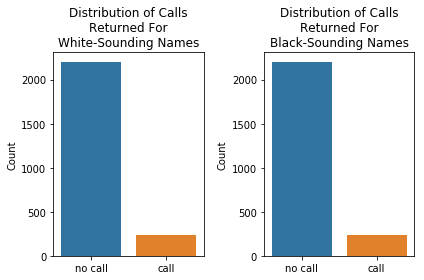

In [23]:
# create bar plots
f, (ax1, ax2) = plt.subplots(1, 2)

# first bar plot: white-sounding names
sns.barplot(x = 'index', y = 'call', data = w_counts_table, ax = ax1)
ax1.set_title('Distribution of Calls\nReturned For\nWhite-Sounding Names')
ax1.set_xticklabels(['no call', 'call'])
ax1.set_xlabel('')
ax1.set_ylabel('Count')

# second bar plot: black-sounding names
sns.barplot(x = 'index', y = 'call', data = w_counts_table, ax = ax2)
ax2.set_title('Distribution of Calls\nReturned For\nBlack-Sounding Names')
ax2.set_xticklabels(['no call', 'call'])
ax2.set_xlabel('')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

Visually, it seems as though there's no significance difference between white-sounding names and black-sounding names.

**Frequentist Approach - Two Sample Z Test, Margin of Error, and Confidence Interval**

Procedure:

1. Assume null hypothesis is true. Since $p_{w} = p_{b}$ under the null hypothesis, it means that $p_{w} - p_{b} = 0$.
2. Calculate the test statistic as follows:

$$Z = \frac{\hat{p}_w - \hat{p}_b - 0}{\sqrt{\hat{p}(1 - \hat{p})(\frac{1}{n_w} + \frac{1}{n_b})}}$$

where

$$\hat{p} = \frac{no.\:of\:calls\:returned_w + no.\:of\:calls\:returned_b}{n_w + n_b}$$

3. Calculate the p-value based on the test statistic.
4. Determine whether to reject the null hypothesis or not at 0.05 significance level.
5. Since the alternative hypothesis is $p_w > p_b$, calculate the margin of error and **one-sided** 95% confidence interval. Margin of error is calculated as follows:

$$margin\:of\:error = z_{\alpha}\sqrt{\frac{\hat{p}_w(1 - \hat{p}_w)}{n_w} + \frac{\hat{p}_b(1 - \hat{p}_b)}{n_b}}$$

Confidence interval is calculated as follows:

$$\left(\:(\hat{p}_w - \hat{p}_b) - margin\:of\:error\:,\:\infty\right)$$

In [7]:
# observed difference
empirical_diff_proportions = p_w - p_b

# overall proportion of returned calls
p_overall = np.mean(data.call)

# calculate the estimated standard error
se = np.sqrt(p_overall * (1 - p_overall) * (1/n_w + 1/n_b))

# test statistic
z = empirical_diff_proportions / se

# p-value
p_value = norm.sf(z)

print('test statistic: {}, p-value: {}'.format(round(z, 2), p_value))

test statistic: 4.11, p-value: 1.9919441665380294e-05


Based on the p-value, I will reject the null hypothesis at 0.05 significance level. The p-value is very small. The difference between the white-sounding names and the black-sounding names seem to be significant.

Let's plot the distribution of the difference of proportions under the null hypothesis and see where the observed difference lies.

/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


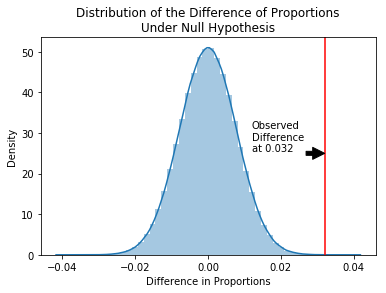

In [16]:
# Distribution under null hypothesis
null_dist = np.random.normal(loc = 0, scale = se, size = 1000000)
_ = sns.distplot(null_dist, norm_hist = True)
_ = plt.axvline(x=empirical_diff_proportions, color = 'red')
_ = plt.title('Distribution of the Difference of Proportions\nUnder Null Hypothesis')
_ = plt.xlabel('Difference in Proportions')
_ = plt.ylabel('Density')
_ = plt.annotate('Observed\nDifference\nat {}'.format(round(empirical_diff_proportions, 3)), 
                 xy = (empirical_diff_proportions, 25), 
                 xytext = (empirical_diff_proportions - 0.02, 25.5), 
                 arrowprops = dict(facecolor = 'black'))
plt.show()

Notice that the area to the right of the observed difference is very small. This is why the p-value is very small.

In [46]:
# 95% CI using z-distribution
z_statistic = norm.ppf(q = 0.95)
z_statistic
# calculate margin of error
margin_of_error = z_statistic * np.sqrt(p_w * (1 - p_w) / n_w + p_b * (1 - p_b) / n_b)
margin_of_error
# 95% CI
conf_95 = empirical_diff_proportions - margin_of_error
print('margin of error: {}'.format(round(margin_of_error, 2)))
display(Math(r'95\%\:Confidence\:Interval:\:({}, \infty)'.format(round(conf_95, 4))))

margin of error: 0.01


<IPython.core.display.Math object>

Notice that the null hypothesis difference of zero is not included in the 95% confidence interval. The confidence interval states that the true difference lies somewhere between 0.0192 and $\infty$ with 95% confidence.

**Bootstrap Approach - Test of Proportions, Margin of Error, and Confidence Interval**

* Null Hypothesis: The proportion of callbacks between the white-sounding names and the black-sounding names are the same.

$$p_{black} = p_{white}$$

* Alternative Hypothesis: The proportion of callbacks for the white-sounding names are greater than the proportion of callbacks for the black-sounding names.

$$p_{black} < p_{white}$$

Procedure:

1. Combine the two samples and calculate the overall proportion of callbacks.
2. Recenter the sample proportions for the two samples.
3. Draw $B$ samples with replacement from the two different recentered samples and calculate the proportion. Here, I use $B = 10000$.
4. Calculate the differences of these $B$ sample proportions between white-sounding names and black-sounding names. This will be the bootstrap sampling distribution of the sample difference in proportions.
5. Calculate the p-value as getting the difference in proportions or greater values than the one I observed in the sample. This is a one-sided test.
6. Compare p-value to significance level $\alpha$. In this case, I'll use $\alpha = 0.05$.
7. Calculate the margin of error and a 95% confidence interval. To do this, I will create a bootstrap sampling distribution of the difference in proportions and calculate the 5th percentile of the distribution. Hence, the **one-sided** confidence interval will be $(5th\:percentile, \infty)$. Margin of error will be $(observed\:difference - 5th\:percentile)$.

In [24]:
# define functions to use for bootstrap method
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1d data"""
    return func(np.random.choice(data, size=len(data)))
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

# recenter the datapoints to have the same mean
w_call_shifted = pd.to_numeric(w) - p_w + p_overall
b_call_shifted = pd.to_numeric(b) - p_b + p_overall

# compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_w = draw_bs_reps(w_call_shifted, np.mean, 10000)
bs_replicates_b = draw_bs_reps(b_call_shifted, np.mean, 10000)

# get replicates of difference of proportions: bs_replicates
bs_replicates = bs_replicates_w - bs_replicates_b

# gompute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_proportions) / 10000
print('p-value =', p)

p-value = 0.0001


Notice that hte p-value is very small. At 0.05 significance level, I will reject the null hypothesis that the two proportions are the same. It seems as though the callback rates for white-sounding names are higher.

/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


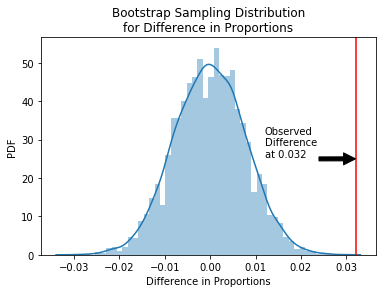

In [22]:
# bootstrap sampling distribution under null hypothesis
_ = sns.distplot(bs_replicates, norm_hist = True)
_ = plt.axvline(x=empirical_diff_proportions, color = 'red')
_ = plt.title('Bootstrap Sampling Distribution\nfor Difference in Proportions')
_ = plt.xlabel('Difference in Proportions')
_ = plt.ylabel('PDF')
_ = plt.annotate('Observed\nDifference\nat {}'.format(round(empirical_diff_proportions, 3)), 
                 xy = (empirical_diff_proportions, 25), 
                 xytext = (empirical_diff_proportions - 0.02, 25.5), 
                 arrowprops = dict(facecolor = 'black'))
plt.show()

From the plot, I can see that the observed difference is very far to the right of 0, the difference in proportions under the null hypothesis.

In [58]:
# construct bootstrap sampling distribution to construct 95% confidence interval
# draw bootstrap samples and calculate proportions
bs_replicates_w = draw_bs_reps(pd.to_numeric(w), np.mean, 10000)
bs_replicates_b = draw_bs_reps(pd.to_numeric(b), np.mean, 10000)

# calculate difference in proportions for all the bootstrap replicates
bs_replicates_diff_proportions = bs_replicates_w - bs_replicates_b

# calculate the 5th percentile of the bootstrap sampling distribution
percentile_5th = np.percentile(bs_replicates_diff_proportions, q = 5)

# margin of error and one-sided 95% confidence interval
print('margin of error: {}'.format(round(empirical_diff_proportions - percentile_5th, 2)))
display(Math(r'95\%\:Confidence\:Interval:\:({}, \infty)'.format(round(percentile_5th, 4))))

margin of error: 0.01


<IPython.core.display.Math object>

Notice that the null hypothesis difference of zero is not included in the 95% confidence interval. The confidence interval states that the true difference lies somewhere between 0.0193 and $\infty$ with 95% confidence.

/root/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


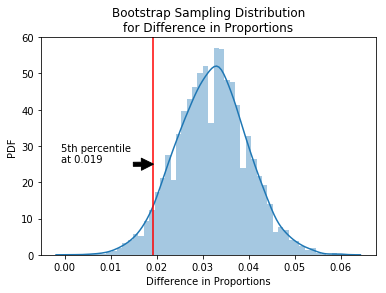

In [63]:
# bootstrap sampling distribution confidence interval
_ = sns.distplot(bs_replicates_diff_proportions, norm_hist = True)
_ = plt.axvline(x=percentile_5th, color = 'red')
_ = plt.title('Bootstrap Sampling Distribution\nfor Difference in Proportions')
_ = plt.xlabel('Difference in Proportions')
_ = plt.ylabel('PDF')
_ = plt.annotate('5th percentile\nat {}'.format(round(percentile_5th, 3)), 
                 xy = (percentile_5th, 25), 
                 xytext = (percentile_5th - 0.02, 25.5), 
                 arrowprops = dict(facecolor = 'black'))
plt.show()

Notice that the confidence interval includes the region to the right of 0.019. Zero is not included in this region.

## 4. Write a story describing the statistical significance in the context or the original problem.

Based on the two-sample z-test of proportions, bootstrap test of proportions, confidence interval based on the normal distribution, and confidence interval based on the bootstrap sampling distribution of the difference in proportions, it seems as though the white-sounding names receive a higher callback rate. The p-values are essentially zero for the tests, which indicate that this is overwhelming evidence to reject the null hypothesis. The confidence intervals constructed do not contain zeros, which indicate that the true difference in proportions probably is not zero.

## 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

Although the statistical analysis shows that callback rate is affected by the names, it is not stating that race/name is the most important factor in callback success. The reason is because there are other factors that need to be considered, such as education level and experience level. I'm not sure how to tweak the experiment to see if this is the most important factor.